Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def train(num_epochs, data, model):

    # covariance matrix before training
    with torch.no_grad():
        X = model.decorrelate(data).reshape(data.shape[0],-1)
        A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        model.forward(data)
        L[epoch] = model.update()
        print(f'epoch {epoch:<3}\tloss: {L[epoch]:3f}')

    # covariance matrix after training
    with torch.no_grad():
        X = model.decorrelate(data).reshape(data.shape[0],-1)
        A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

epoch 0  	loss: 0.085959
epoch 1  	loss: 0.025799
epoch 2  	loss: 0.016671
epoch 3  	loss: 0.011910
epoch 4  	loss: 0.008920
epoch 5  	loss: 0.006913
epoch 6  	loss: 0.005521
epoch 7  	loss: 0.004531
epoch 8  	loss: 0.003808
epoch 9  	loss: 0.003269
epoch 10 	loss: 0.002857
epoch 11 	loss: 0.002537
epoch 12 	loss: 0.002283
epoch 13 	loss: 0.002078
epoch 14 	loss: 0.001911
epoch 15 	loss: 0.001772
epoch 16 	loss: 0.001656
epoch 17 	loss: 0.001558
epoch 18 	loss: 0.001473
epoch 19 	loss: 0.001401
epoch 20 	loss: 0.001338
epoch 21 	loss: 0.001282
epoch 22 	loss: 0.001233
epoch 23 	loss: 0.001190
epoch 24 	loss: 0.001151
epoch 25 	loss: 0.001116
epoch 26 	loss: 0.001084
epoch 27 	loss: 0.001055
epoch 28 	loss: 0.001029
epoch 29 	loss: 0.001005
epoch 30 	loss: 0.000983
epoch 31 	loss: 0.000962
epoch 32 	loss: 0.000943
epoch 33 	loss: 0.000925
epoch 34 	loss: 0.000909
epoch 35 	loss: 0.000893
epoch 36 	loss: 0.000879
epoch 37 	loss: 0.000865
epoch 38 	loss: 0.000852
epoch 39 	loss: 0.000840


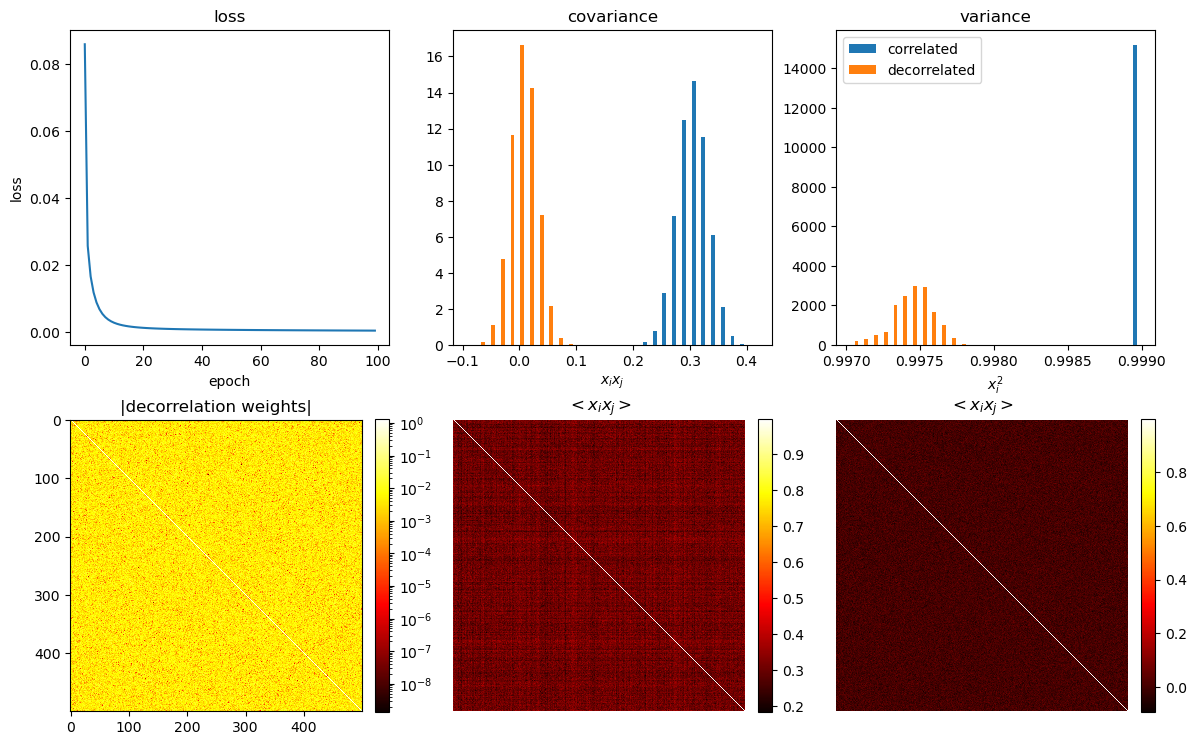

In [3]:
num_samples=1000
num_features=500
num_epochs=100
seed=42
decor_lr=1e-0
kappa=1e-1
method='normalized'

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, method=method, decor_lr=decor_lr, kappa=kappa).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the same for learning a lower triangular matrix

epoch 0  	loss: 1.512978
epoch 1  	loss: 0.973337
epoch 2  	loss: 0.682329
epoch 3  	loss: 0.506411
epoch 4  	loss: 0.391575
epoch 5  	loss: 0.312325
epoch 6  	loss: 0.255269
epoch 7  	loss: 0.212795
epoch 8  	loss: 0.180310
epoch 9  	loss: 0.154899
epoch 10 	loss: 0.134644
epoch 11 	loss: 0.118235
epoch 12 	loss: 0.104754
epoch 13 	loss: 0.093542
epoch 14 	loss: 0.084117
epoch 15 	loss: 0.076115
epoch 16 	loss: 0.069265
epoch 17 	loss: 0.063353
epoch 18 	loss: 0.058217
epoch 19 	loss: 0.053724
epoch 20 	loss: 0.049772
epoch 21 	loss: 0.046276
epoch 22 	loss: 0.043168
epoch 23 	loss: 0.040393
epoch 24 	loss: 0.037904
epoch 25 	loss: 0.035662
epoch 26 	loss: 0.033636
epoch 27 	loss: 0.031798
epoch 28 	loss: 0.030126
epoch 29 	loss: 0.028600
epoch 30 	loss: 0.027202
epoch 31 	loss: 0.025919
epoch 32 	loss: 0.024738
epoch 33 	loss: 0.023649
epoch 34 	loss: 0.022641
epoch 35 	loss: 0.021707
epoch 36 	loss: 0.020839
epoch 37 	loss: 0.020032
epoch 38 	loss: 0.019279
epoch 39 	loss: 0.018575


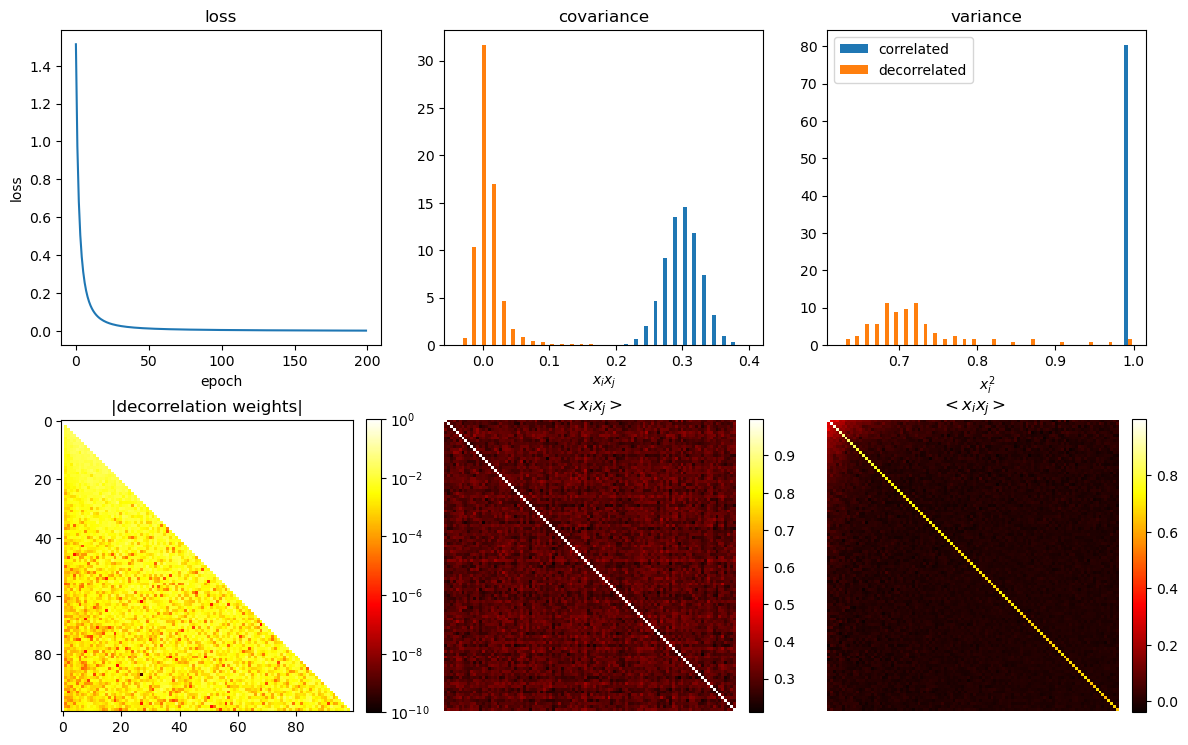

In [4]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-1
kappa=1e-3
method='normalized'

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, method=method, decor_lr=decor_lr, kappa=kappa, full=False).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the impact of debiasing of the data (will have positive effect if weights start to grow during optimization; may allow even higher stable decorrelation learning rates)

epoch 0  	loss: 6.371860
epoch 1  	loss: 1.712334
epoch 2  	loss: 0.917720
epoch 3  	loss: 0.589865
epoch 4  	loss: 0.417673
epoch 5  	loss: 0.314656
epoch 6  	loss: 0.247629
epoch 7  	loss: 0.201348
epoch 8  	loss: 0.167933
epoch 9  	loss: 0.142948
epoch 10 	loss: 0.123729
epoch 11 	loss: 0.108594
epoch 12 	loss: 0.096436
epoch 13 	loss: 0.086499
epoch 14 	loss: 0.078257
epoch 15 	loss: 0.071330
epoch 16 	loss: 0.065440
epoch 17 	loss: 0.060378
epoch 18 	loss: 0.055987
epoch 19 	loss: 0.052144
epoch 20 	loss: 0.048756
epoch 21 	loss: 0.045747
epoch 22 	loss: 0.043057
epoch 23 	loss: 0.040637
epoch 24 	loss: 0.038449
epoch 25 	loss: 0.036459
epoch 26 	loss: 0.034643
epoch 27 	loss: 0.032976
epoch 28 	loss: 0.031441
epoch 29 	loss: 0.030023
epoch 30 	loss: 0.028707
epoch 31 	loss: 0.027483
epoch 32 	loss: 0.026341
epoch 33 	loss: 0.025272
epoch 34 	loss: 0.024270
epoch 35 	loss: 0.023327
epoch 36 	loss: 0.022440
epoch 37 	loss: 0.021602
epoch 38 	loss: 0.020810
epoch 39 	loss: 0.020059


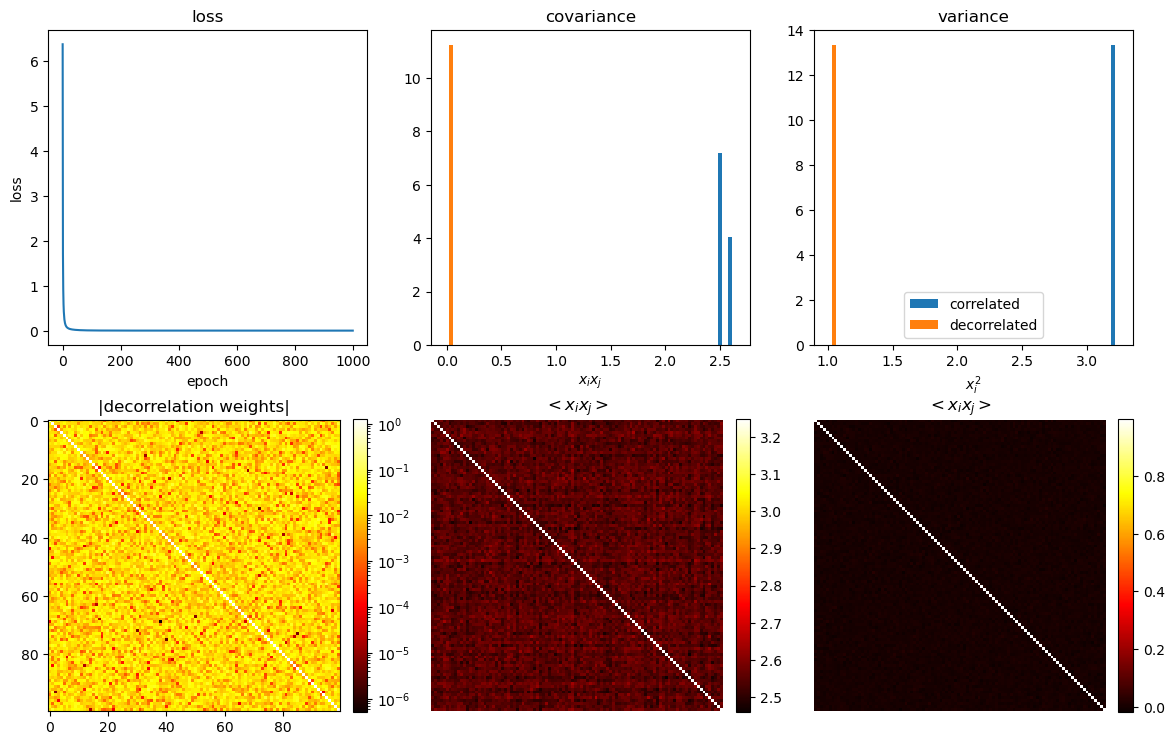

In [5]:
num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1e-1
kappa=1e-1
method='normalized'

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device) + 1.5

# create a decorrelator
model = Decorrelation(in_features=num_features, method=method, decor_lr=decor_lr, kappa=kappa).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Shows how offsets lead to huge gradients

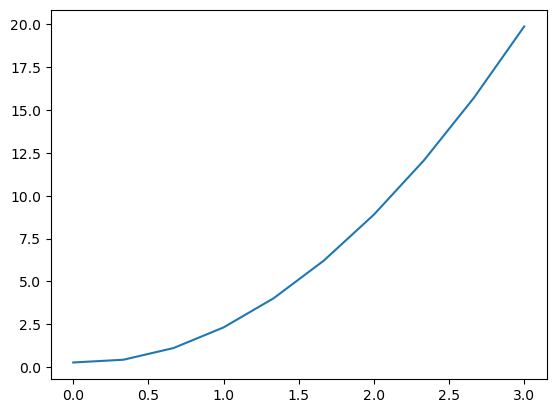

In [6]:
import copy

num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1
kappa=1e-1
method='normalized'

offsets = np.linspace(0, 3, 10)

grads = torch.zeros(len(offsets))
for i, offset in enumerate(offsets):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    data = generate_correlated_data(num_features, num_samples).to(device) + offset

    # create a decorrelator
    model = Decorrelation(in_features=num_features, method=method, decor_lr=decor_lr, kappa=kappa).to(device)

    w_old = copy.deepcopy(model.weight.data)
    model.forward(data)
    model.update()
    grads[i] = torch.norm(model.weight-w_old)

plt.plot(offsets, grads);

Decorrelation of a convolutional input

epoch 0  	loss: 0.078766
epoch 1  	loss: 0.018917
epoch 2  	loss: 0.008616
epoch 3  	loss: 0.008557
epoch 4  	loss: 0.003340
epoch 5  	loss: 0.003310
epoch 6  	loss: 0.001763
epoch 7  	loss: 0.001656
epoch 8  	loss: 0.002559
epoch 9  	loss: 0.000652
epoch 10 	loss: 0.000390
epoch 11 	loss: 0.000712
epoch 12 	loss: 0.000379
epoch 13 	loss: 0.000187
epoch 14 	loss: 0.000266
epoch 15 	loss: 0.000130
epoch 16 	loss: 0.000776
epoch 17 	loss: 0.000297
epoch 18 	loss: 0.000537
epoch 19 	loss: 0.000136
epoch 20 	loss: 0.000295
epoch 21 	loss: 0.000252
epoch 22 	loss: 0.000365
epoch 23 	loss: 0.000412
epoch 24 	loss: 0.000230
epoch 25 	loss: 0.000144
epoch 26 	loss: 0.000410
epoch 27 	loss: 0.000254
epoch 28 	loss: 0.000526
epoch 29 	loss: 0.000268
epoch 30 	loss: 0.000209
epoch 31 	loss: 0.000273
epoch 32 	loss: 0.000143
epoch 33 	loss: 0.000227
epoch 34 	loss: 0.000281
epoch 35 	loss: 0.000149
epoch 36 	loss: 0.000275
epoch 37 	loss: 0.000203
epoch 38 	loss: 0.000359
epoch 39 	loss: 0.000177


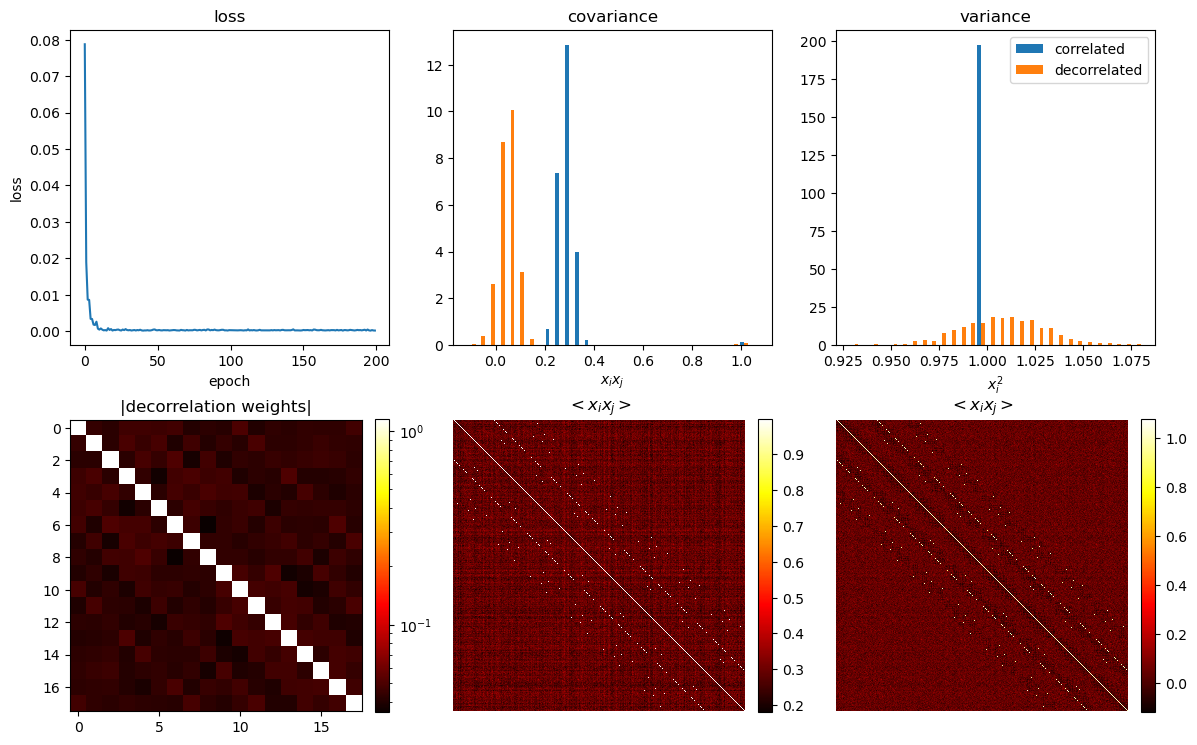

In [7]:
# generate [N, M] correlated input
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
seed=42
decor_lr=1e-0
kappa=1e-1
downsample_perc=0.1
method='normalized'

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

data = generate_correlated_data(num_features, num_samples).reshape(num_samples,in_channels,height,width).to(device)

# d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
# data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, method=method, decor_lr=decor_lr, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Test the effect of downsampling

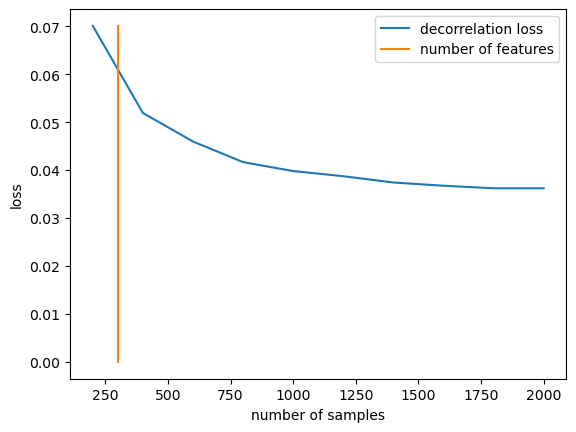

In [8]:
def compute_decor_sample_size(decor_lr, num_samples, num_features):
    
    num_epochs=50
    seed=42
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    data = generate_correlated_data(num_features, num_samples).to(device)

    percs = torch.linspace(0.1,1,10)
    L = torch.zeros(len(percs))
    for i, p in enumerate(percs):

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        model = Decorrelation(in_features=num_features, method='normalized', decor_lr=decor_lr, kappa=0.5).to(device)

        num_samples = int(len(data) * p)
        idx = np.random.choice(np.arange(len(data)), size=num_samples)

        loss = 0
        for j in range(num_epochs):
            model.forward(data[idx])
            loss = model.update()
        
        L[i] = loss

    return L, percs

decor_lr=1e0
num_samples=2000
num_features=300
L, percs = compute_decor_sample_size(decor_lr, num_samples, num_features)

plt.plot(percs*num_samples, L)
plt.plot([num_features, num_features],[0, max(L)])
plt.xlabel('number of samples')
plt.ylabel('loss');
plt.legend(['decorrelation loss', 'number of features']);

Test impact of decorrelation strength

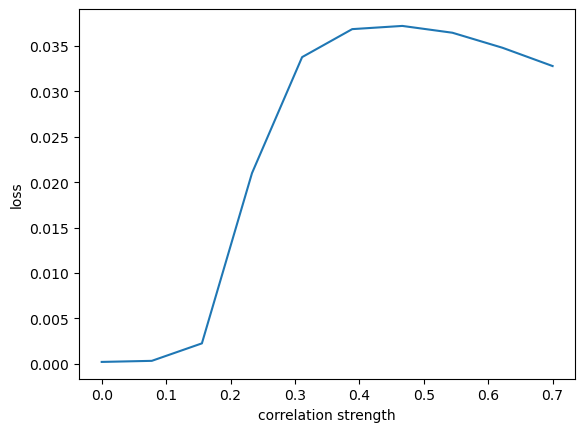

In [9]:
def compute_decor_strength(decor_lr, num_samples, num_features):
    
    num_epochs=50
    seed=42
    
    percs = torch.linspace(0,0.7,10)
    L = torch.zeros(len(percs))
    for i, p in enumerate(percs):

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        # generate correlated data
        data = generate_correlated_data(num_features, num_samples, strength=p).to(device)

        model = Decorrelation(in_features=num_features, method='normalized', decor_lr=decor_lr, kappa=0.5).to(device)

        loss = 0
        for j in range(num_epochs):
            model.forward(data)
            loss = model.update()
        
        L[i] = loss

    return L, percs

decor_lr=1e0
num_samples=2000
num_features=300
L, percs = compute_decor_strength(decor_lr, num_samples, num_features)

plt.plot(percs, L)
plt.xlabel('correlation strength')
plt.ylabel('loss');